# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [215]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [216]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [217]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [218]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [219]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [220]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for 0_W
Gradient check passed!
Checking gradient for 0_B
Gradient check passed!
Checking gradient for 2_W
Gradient check passed!
Checking gradient for 2_B
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [221]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for 0_W
Gradient check passed!
Checking gradient for 0_B
Gradient check passed!
Checking gradient for 2_W
Gradient check passed!
Checking gradient for 2_B
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [222]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [245]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg =0.001) # 1e1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 38.444035, Train accuracy: 0.349222, val accuracy: 0.342000
Loss: 30.208532, Train accuracy: 0.547889, val accuracy: 0.527000
Loss: 25.984683, Train accuracy: 0.622556, val accuracy: 0.608000
Loss: 22.586688, Train accuracy: 0.654444, val accuracy: 0.621000
Loss: 20.828449, Train accuracy: 0.705000, val accuracy: 0.674000
Loss: 29.081453, Train accuracy: 0.690778, val accuracy: 0.666000
Loss: 11.820149, Train accuracy: 0.731333, val accuracy: 0.666000
Loss: 10.168386, Train accuracy: 0.726111, val accuracy: 0.661000
Loss: 9.184969, Train accuracy: 0.744222, val accuracy: 0.667000
Loss: 4.667126, Train accuracy: 0.781444, val accuracy: 0.693000
Loss: 23.490488, Train accuracy: 0.773111, val accuracy: 0.696000
Loss: 12.687362, Train accuracy: 0.798889, val accuracy: 0.712000
Loss: 9.343138, Train accuracy: 0.792778, val accuracy: 0.699000
Loss: 8.946653, Train accuracy: 0.829222, val accuracy: 0.716000
Loss: 11.246868, Train accuracy: 0.818444, val accuracy: 0.719000
Loss: 15.42280

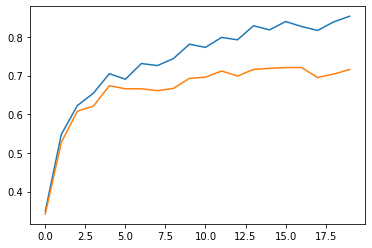

In [246]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [248]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 0.001) # 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 36.879578, Train accuracy: 0.366667, val accuracy: 0.359000
Loss: 26.713725, Train accuracy: 0.564667, val accuracy: 0.538000
Loss: 22.124914, Train accuracy: 0.611111, val accuracy: 0.601000
Loss: 15.014181, Train accuracy: 0.668778, val accuracy: 0.647000
Loss: 20.625983, Train accuracy: 0.683778, val accuracy: 0.654000
Loss: 14.956174, Train accuracy: 0.723889, val accuracy: 0.682000
Loss: 17.804577, Train accuracy: 0.726111, val accuracy: 0.678000
Loss: 16.709146, Train accuracy: 0.747111, val accuracy: 0.685000
Loss: 15.136138, Train accuracy: 0.774889, val accuracy: 0.697000
Loss: 10.408046, Train accuracy: 0.774333, val accuracy: 0.690000
Loss: 10.970575, Train accuracy: 0.808333, val accuracy: 0.703000
Loss: 26.345781, Train accuracy: 0.779667, val accuracy: 0.681000
Loss: 6.205351, Train accuracy: 0.804667, val accuracy: 0.708000
Loss: 19.609334, Train accuracy: 0.794667, val accuracy: 0.707000
Loss: 9.559350, Train accuracy: 0.832778, val accuracy: 0.732000
Loss: 8.0243

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [249]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg =0.001) # 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 43.790244, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 43.281486, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 43.109122, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 42.407352, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 44.410978, Train accuracy: 0.221111, val accuracy: 0.231000
Loss: 37.225088, Train accuracy: 0.261333, val accuracy: 0.261000
Loss: 37.689115, Train accuracy: 0.273222, val accuracy: 0.270000
Loss: 40.154990, Train accuracy: 0.318667, val accuracy: 0.324000
Loss: 39.945739, Train accuracy: 0.383667, val accuracy: 0.367000
Loss: 29.950591, Train accuracy: 0.429333, val accuracy: 0.424000
Loss: 33.510330, Train accuracy: 0.471333, val accuracy: 0.455000
Loss: 38.895270, Train accuracy: 0.526333, val accuracy: 0.522000
Loss: 29.543665, Train accuracy: 0.563444, val accuracy: 0.548000
Loss: 27.222140, Train accuracy: 0.587667, val accuracy: 0.569000
Loss: 34.525315, Train accuracy: 0.612000, val accuracy: 0.591000
Loss: 17.4

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [273]:
# выше менял reg

In [274]:
# ИЗМЕНИЛ ГИПЕРПАРАМЕТРЫ

data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-2)# 0.001)# 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-2, num_epochs=150, batch_size=5)


# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 11.545063, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.529624, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.464732, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 11.385396, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 11.439848, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 11.255600, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 11.148345, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 11.355793, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 11.507920, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 11.499652, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 10.918439, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 10.864322, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 11.098542, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 10.896873, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 9.981914, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 11.25

Loss: 0.506545, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 0.345916, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 0.225324, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 0.464166, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 0.307406, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 0.167503, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 0.452729, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 0.267208, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 0.403749, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 0.284669, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 0.443613, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 0.376238, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 0.236467, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 0.242468, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 0.368469, Train accuracy: 1.000000, val accuracy: 0.066667


Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [300]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-2, num_epochs=20, batch_size=5 , 
                 learning_rate_decay=0.99999)
# MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99
loss_history, train_history, val_history = trainer.fit()

Loss: 11.535030, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 11.431229, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.249207, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 11.353869, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 10.466695, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 10.245707, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 8.070540, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 10.446279, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 14.844004, Train accuracy: 0.400000, val accuracy: 0.066667
Loss: 8.432337, Train accuracy: 0.400000, val accuracy: 0.133333
Loss: 10.779206, Train accuracy: 0.466667, val accuracy: 0.066667
Loss: 10.942482, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 7.234032, Train accuracy: 0.600000, val accuracy: 0.000000
Loss: 3.917836, Train accuracy: 0.733333, val accuracy: 0.066667
Loss: 2.452774, Train accuracy: 0.733333, val accuracy: 0.000000
Loss: 4.142696,

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [301]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg =0.001) # 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 43.775147, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 41.051883, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 41.936233, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 46.746398, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 38.138885, Train accuracy: 0.231000, val accuracy: 0.239000
Loss: 45.921836, Train accuracy: 0.268111, val accuracy: 0.266000
Loss: 40.344411, Train accuracy: 0.281222, val accuracy: 0.287000
Loss: 39.959366, Train accuracy: 0.334667, val accuracy: 0.340000
Loss: 30.910091, Train accuracy: 0.406667, val accuracy: 0.398000
Loss: 27.576224, Train accuracy: 0.444222, val accuracy: 0.438000
Loss: 25.346305, Train accuracy: 0.494444, val accuracy: 0.491000
Loss: 34.031810, Train accuracy: 0.528333, val accuracy: 0.514000
Loss: 29.992170, Train accuracy: 0.568778, val accuracy: 0.564000
Loss: 28.089445, Train accuracy: 0.588222, val accuracy: 0.578000
Loss: 23.396993, Train accuracy: 0.615111, val accuracy: 0.607000
Loss: 23.4

In [ ]:
# Let's train the best one-hidden-layer network we can

learning_rates = 1e-4
reg_strength = 1e-3
learning_rate_decay = 0.999
hidden_layer_size = 128
num_epochs = 200
batch_size = 64

best_classifier = None
best_val_accuracy = None

loss_history = []
train_history = []
val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

print('best validation accuracy achieved: %f' % best_val_accuracy)

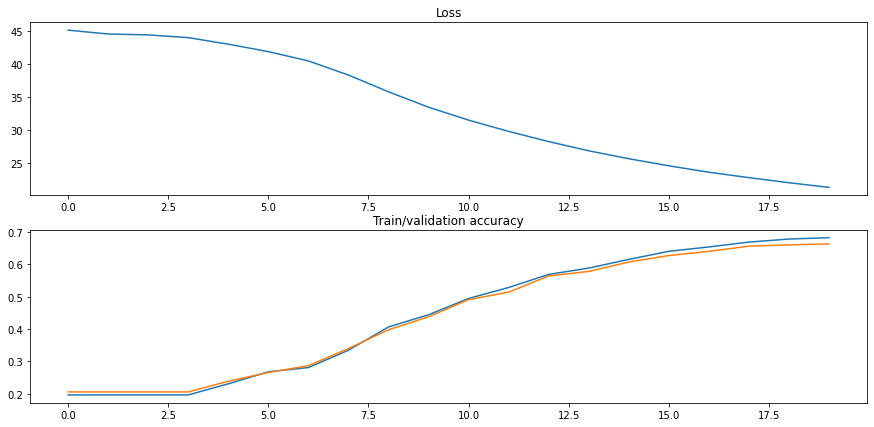

In [302]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

In [303]:
best_classifier = model

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [304]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.630000
